# Training a FNO on the Shallow Water equations


In [1]:
import time
import sys
import h5py
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR, OneCycleLR

# Neural Operator Imports
from neuralop.models import FNO, TFNO
from neuralop import Trainer, LpLoss, H1Loss
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params

# Uncomment the following line if using progress bars
from tqdm.autonotebook import tqdm, trange

#from tabulate import tabulate
import time

C:\Users\Matteo\AppData\Local\Temp\ipykernel_580\1761379650.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Inital condition: Gauss function

Load data from h5 file.

In [2]:
# Load data
with h5py.File(r'C:\Users\Matteo\Shallow-Water-Equations\dataFNO\data_sigma_no1mu_no1.h5', 'r') as file:
#with h5py.File(r'C:\Users\Matteo\Shallow-Water-Equations\dataFNO\swe1d_data_gauss_middle.h5', 'r') as file:
    for key in file.keys():
        print(f"Key: {key}")
        # Check if each key is a dataset or a group
        item = file[key]
        if isinstance(item, h5py.Group):
            print(f"  '{key}' is a group containing:")
            for sub_key in item.keys():
                if sub_key.startswith("__"):
                    continue
                print(f"    {sub_key}")
        elif isinstance(item, h5py.Dataset):
            print(f" '{key}' is a dataset with shape {item.shape} and dtype {item.dtype}")

    h_all = np.array(file['data_0']['h_all'])
    u_all = np.array(file['data_0']['u_all'])
    x = np.array(file['data_0']['x'])
    time_all = np.array(file['data_0']['time_all'])
    print(f"'h_all' loaded with shape: {h_all.shape}")
    print(f"'u_all' loaded with shape: {u_all.shape}")
    print(f"'x' loaded with shape: {x.shape}")
    print(f"'time_all' loaded with shape: {time_all.shape}")


Key: data_0
  'data_0' is a group containing:
    h0
    h_all
    mu
    sigma
    time_all
    u_all
    x
'h_all' loaded with shape: (731, 200)
'u_all' loaded with shape: (731, 200)
'x' loaded with shape: (1, 200)
'time_all' loaded with shape: (730, 1)


In [3]:
def prepare_data(h_all, x, p_train, p_val):
    x = x.squeeze()
    h_all = np.real(h_all)

    # Input a
    a = h_all[:-1]
    a = a[:, np.newaxis, :]
    # Target u (one time step after a)
    u = h_all[1:]
    u = u[:, np.newaxis, :]

    mesh = x
    mesh_shape_corrected = np.repeat(mesh[np.newaxis, np.newaxis, :], u.shape[0], axis=0)

    # Concatenate a with mesh_shape_corrected
    a_with_mesh = np.concatenate([a, mesh_shape_corrected], axis=1)
    print(a_with_mesh.shape)

    # Concatenate u with mesh_shape_corrected
    u_with_mesh = np.concatenate([u, mesh_shape_corrected], axis=1)
    print(u_with_mesh.shape)

    n = len(a_with_mesh)
    print(n)

    # Split data into training, validation and test sets
    n_train = int(p_train * n)
    n_val = int(p_val * n)
    n_test = n - n_train - n_val

    print(f"n_train = {n_train}, n_val = {n_val}, n_test = {n_test}")

    train_x = torch.tensor(a[:n_train], dtype=torch.float32)  # Shape (n_train, 3, 256)
    val_x = torch.tensor(a[n_train:n_train + n_val], dtype=torch.float32)  # Shape (n_val, 3, 256)
    test_x = torch.tensor(a[n_train + n_val:], dtype=torch.float32)  # Shape (n_test, 3, 256)

    train_y = torch.tensor(u[:n_train], dtype=torch.float32)  # Shape (n_train, ...)
    val_y = torch.tensor(u[n_train:n_train + n_val], dtype=torch.float32)  # Shape (n_val, ...)
    test_y = torch.tensor(u[n_train + n_val:], dtype=torch.float32)  # Shape (n_test, ...)

    print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)

    return n_train, n_val, n_test, mesh, a_with_mesh, u_with_mesh, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y


In [4]:
p_train = 0.6
p_val = 0.2
p_test = 1 - p_train - p_val
n_train, n_val, n_test, mesh, a_with_mesh, u_with_mesh, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(h_all, x, p_train, p_val)

(730, 2, 200)
(730, 2, 200)
730
n_train = 438, n_val = 146, n_test = 146
torch.Size([438, 1, 200]) torch.Size([438, 1, 200]) torch.Size([146, 1, 200]) torch.Size([146, 1, 200]) torch.Size([146, 1, 200]) torch.Size([146, 1, 200])


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [6]:
model = TFNO(
    n_modes=(16,), 
    in_channels=1,
    lifting_channels=64, 
    hidden_channels=64, 
    projection_channels=64, 
    out_channels=1, 
    non_linearity=torch.functional.F.relu)

n_params = count_model_params(model)
print(f'\nThe model has {n_params} parameters.')


The model has 308929 parameters.


In [7]:
batch_size = 32

train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

val_dataset = torch.utils.data.TensorDataset(val_x, val_y)
dataloader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

learn_rate = 1e-3
# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

In [8]:
loss_train = []
loss_val = []
best_val_loss = np.inf

model.to(device)

# Time training
start_time = time.time()

# Training loop
n_epochs = 20
for epoch in tqdm(range(n_epochs), unit='epoch'):
    model.train()
    epoch_train_loss = 0

    for x, y in dataloader_train:
        x = x.to(device)
        y = y.to(device)

        # Forward pass
        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate epoch loss
        epoch_train_loss += loss.item() * x.size(0) # loss.item() is the average loss of the batch

    # Validation loss
    model.eval() # Set model to evaluation mode
    epoch_val_loss = 0
    with torch.no_grad(): # Disable gradient tracking
        for x_val, y_val in dataloader_val:
            x_val = y_val.to(device)
            y_val = y_val.to(device)
            val_y_pred = model(x_val)
            val_loss = loss_fn(val_y_pred, y_val)
            epoch_val_loss += val_loss.item() * x_val.size(0) 
            

    # Average losses
    epoch_train_loss /= len(train_dataset)
    epoch_val_loss /= len(val_dataset)

    # Append losses
    loss_train.append(epoch_train_loss)
    loss_val.append(epoch_val_loss)

    # Print epoch loss
    if epoch % 10 == 9:
        print(f'Epoch {epoch + 1}/{n_epochs}: Training loss: {epoch_train_loss:.6f}, Validation loss: {epoch_val_loss:.6f}')


# Time training
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")



  0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch 10/100: Training loss: 0.000312, Validation loss: 0.000349
Epoch 20/100: Training loss: 0.000045, Validation loss: 0.000083
Epoch 30/100: Training loss: 0.000028, Validation loss: 0.000034
Epoch 40/100: Training loss: 0.000042, Validation loss: 0.000050
Epoch 50/100: Training loss: 0.000019, Validation loss: 0.000031
Epoch 60/100: Training loss: 0.000018, Validation loss: 0.000028
Epoch 70/100: Training loss: 0.000017, Validation loss: 0.000029
Epoch 80/100: Training loss: 0.000015, Validation loss: 0.000031
Epoch 90/100: Training loss: 0.000014, Validation loss: 0.000035
Epoch 100/100: Training loss: 0.000016, Validation loss: 0.000038
Training time: 126.00 seconds


Plot training and validation loss. Iteration = n_epochs x n_batches.

In [21]:
x.shape

torch.Size([32, 1, 200])

In [9]:
save = 0

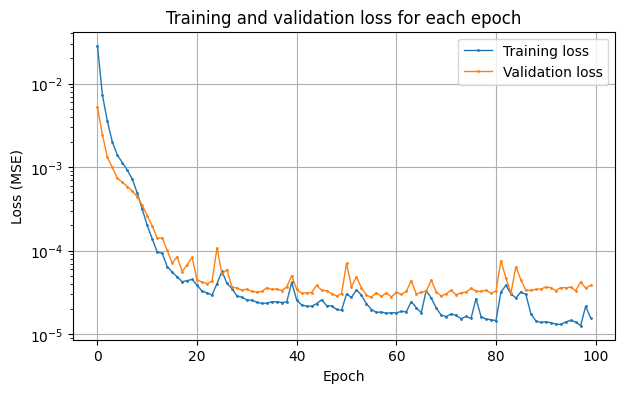

In [10]:
plt.figure(figsize=(7, 4))
plt.plot(loss_train, '.-', label='Training loss', linewidth=1, markersize=2)
plt.plot(loss_val, '.-', label='Validation loss', linewidth=1, markersize=2)
plt.yscale('log')
plt.legend()
plt.grid()
plt.title('Training and validation loss for each epoch')
#plt.title('Training loss for each epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')

if save:
    plt.savefig(f'plots/loss_swe_epochs{n_epochs}_channels{model.lifting_channels}_lr_{learn_rate}.pdf', format='pdf')

plt.show()

In [11]:
# Make predictions
pred_train = model(train_x).cpu().detach().numpy()
pred_val = model(val_x).cpu().detach().numpy()
pred_test = model(test_x).cpu().detach().numpy()

# Combine pred_train, pred_val and pred_test
pred_all = np.concatenate([pred_train, pred_val, pred_test], axis=0)
#pred_all = np.concatenate([pred_train, pred_test], axis=0)
print(pred_all.shape)

# Calculate loss
test_loss = loss_fn(torch.tensor(pred_all[:, 0, :]), torch.tensor(u[:, 0, :])).item()

print(f"Loss: {test_loss:.2e}")

(730, 1, 200)
Loss: 2.51e-05


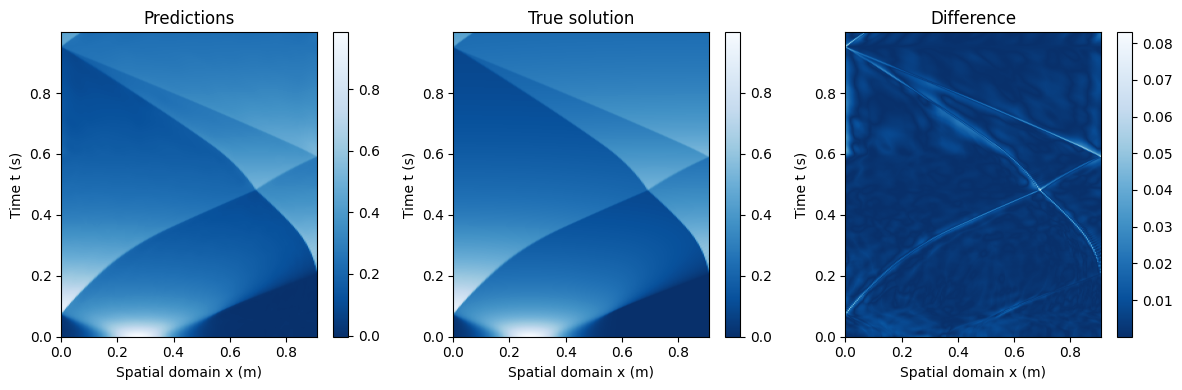

In [12]:
# Assuming x and time_all correspond to the spatial and time dimensions
X, T = np.meshgrid(x, time_all.squeeze())

cmap = 'Blues_r'

# Plot predictions
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# Define the extent based on X and T
extent = [X.min(), X.max(), T.max(), T.min()]  

# Prediction plot
im1 = ax[0].imshow(pred_all[:, 0, :], aspect='auto', extent=extent, cmap=cmap)
ax[0].set_title("Predictions")
ax[0].set_xlabel("Spatial domain x (m)")
ax[0].set_ylabel("Time t (s)")
ax[0].invert_yaxis()
plt.colorbar(im1, ax=ax[0])

# True solution plot
im2 = ax[1].imshow(u[:, 0, :], aspect='auto', extent=extent, cmap=cmap)
ax[1].set_title("True solution")
ax[1].set_xlabel("Spatial domain x (m)")
ax[1].set_ylabel("Time t (s)")
ax[1].invert_yaxis()
plt.colorbar(im2, ax=ax[1])

# Difference plot
im3 = ax[2].imshow(np.abs(pred_all[:, 0, :] - u[:, 0, :]), aspect='auto', extent=extent, cmap=cmap)
ax[2].set_title("Difference")
ax[2].set_xlabel("Spatial domain x (m)")
ax[2].set_ylabel("Time t (s)")
ax[2].invert_yaxis()
plt.colorbar(im3, ax=ax[2])

plt.tight_layout()

if save:
    plt.savefig(f'plots/pred_swe_epochs{n_epochs}_channels{model.lifting_channels}_lr_{learn_rate}.pdf', format='pdf')

plt.show()


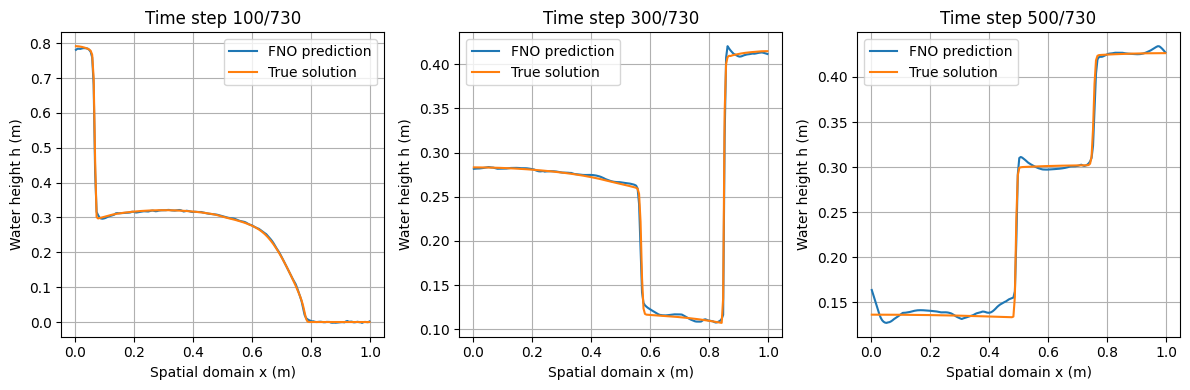

In [13]:
# Plot for some time steps
indices = [100, 300, 500]

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(mesh, pred_all[indices[0], 0, :], label='FNO prediction')
plt.plot(mesh, u[indices[0], 0, :], label='True solution')
plt.xlabel('Spatial domain x (m)')
plt.ylabel('Water height h (m)')
plt.legend()
plt.grid()
plt.title(f"Time step {indices[0]}/{n}")

plt.subplot(1, 3, 2)
plt.plot(mesh, pred_all[indices[1], 0, :], label='FNO prediction')
plt.plot(mesh, u[indices[1], 0, :], label='True solution')
plt.xlabel('Spatial domain x (m)')
plt.ylabel('Water height h (m)')
plt.legend()
plt.grid()
plt.title(f"Time step {indices[1]}/{n}")

plt.subplot(1, 3, 3)
plt.plot(mesh, pred_all[indices[2], 0, :], label='FNO prediction')
plt.plot(mesh, u[indices[2], 0, :], label='True solution')
plt.xlabel('Spatial domain x (m)')
plt.ylabel('Water height h (m)')
plt.legend()
plt.grid()
plt.title(f"Time step {indices[2]}/{n}")

plt.tight_layout()

if save:
    plt.savefig(f'plots/pred_swe_epochs{n_epochs}_channels{model.lifting_channels}_lr_{learn_rate}_timesteps.pdf', format='pdf')

plt.show()

(730,)


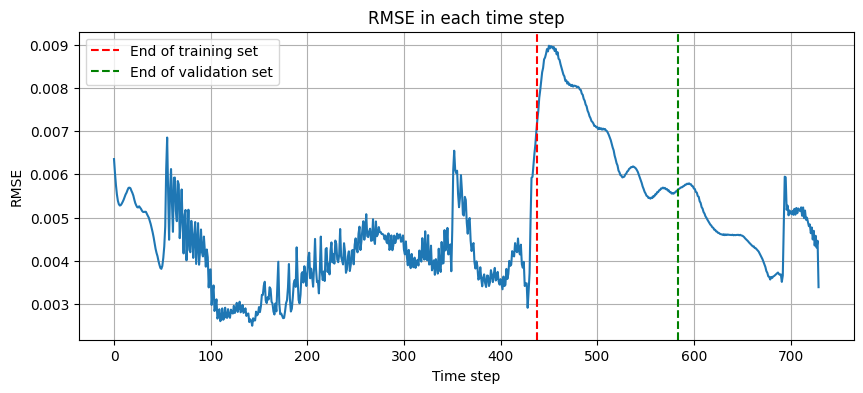

In [14]:
# Plot the RMSE in each time step
rmse = np.sqrt(np.mean((pred_all - u) ** 2, axis=(1, 2)))
print(rmse.shape)

plt.figure(figsize=(10, 4))
plt.plot(rmse)
plt.axvline(x=n_train, color='r', linestyle='--', label='End of training set')
plt.axvline(x=n_train + n_val, color='g', linestyle='--', label='End of validation set')
plt.xlabel('Time step')
plt.ylabel('RMSE')
plt.title('RMSE in each time step')
plt.legend()
plt.grid()

if save:
    plt.savefig(f'plots/rmse_swe_epochs{n_epochs}_channels{model.lifting_channels}_lr_{learn_rate}.pdf', format='pdf')

plt.show()